In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

In [2]:
np.random.seed(42)
random.seed(42)

# WORK IN PROGRESS! NOT READY FOR USE YET

# Creation of Train and Test Set

As the dataset at the moment is not splitted at all, we need a dedicated train and testset.

This notebook lead through the process of creating such a split and can be used to transform the originial dataset in our training and test sets.

There are multiple key factors to consider when creating a testset:
- Temporal drift
- Cold-Start problem
- Distribution similarity

## Temporal drift
Over time there will most likely happen a concept drift leading to different distributions. To predict a value you look into the past. You dont predict a value of the past with the knowledge of the future as this would led to some kind of data leakage.

## Cold-Start problem
This is one of the most central aspects a recommender system has to deal with. The cold start problem referes to the fact if a user/item is already known at training time or is first introduced at test time.
We have the following 4 cases we want to cover extensively in order to have a full diagnostic view about our model performance.
- Hot/Hot (Known User/ Known Wine) -> Standard case
- Hot/Cold (Known User/ New Wine) -> A new wine is introduced
- Cold/Hot (New User/ Known Wine) -> New user get some Wine recommendations
- Cold/Cold (New User/ New Wine) -> most challenging case, first time user sees a brand new wine


## Distribution similarity

In [3]:
df_reviews = pd.read_csv(r"../../All-XWines_Full_100K_wines_21M_ratings/XWines_Full_21M_ratings.csv")

C:\Users\frede\AppData\Local\Temp\ipykernel_21624\3958815110.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews = pd.read_csv(r"../../All-XWines_Full_100K_wines_21M_ratings/XWines_Full_21M_ratings.csv")


In [4]:
df_reviews["Date"] = pd.to_datetime(df_reviews["Date"])

In [5]:
df_reviews = df_reviews.sort_values("Date")

In [6]:
df_reviews.head(10)

,RatingID,UserID,WineID,Vintage,Rating,Date
838057,838058,1395486,136168,2005,2.0,2012-01-03 08:20:53
1582521,1582522,1395486,174565,2008,4.0,2012-01-03 08:27:03
1578306,1578307,1385968,165088,2008,1.0,2012-01-04 10:34:12
725564,725565,1576414,136365,2004,4.0,2012-01-07 14:18:01
2985506,2985507,1177579,114749,2010,3.0,2012-01-11 15:01:43
1392601,1392602,1187471,174257,2007,4.0,2012-01-11 17:51:49
1578604,1578605,1855030,115399,2008,4.0,2012-01-14 13:41:43
2080735,2080736,1855030,117018,2009,4.0,2012-01-14 13:42:47
302652,302653,1785135,111511,1998,4.0,2012-01-14 15:54:09
1579771,1579772,1193574,136595,2008,5.0,2012-01-14 16:15:04


In [7]:
# create a 80/20 temporal split
split_ratio = 0.80
split_index = int(len(df_reviews) * split_ratio)
df_reviews_train = df_reviews.iloc[:split_index]
df_reviews_test = df_reviews.iloc[split_index:]
print(f"Size of all reviews: {len(df_reviews)}")
print(f"Size of train set: {len(df_reviews_train)}")
print(f"Size of test set: {len(df_reviews_test)} making it {(len(df_reviews_test) / (len(df_reviews_test) + len(df_reviews_train)))*100} %")

Size of all reviews: 21013536
Size of train set: 16810828
Size of test set: 4202708 making it 20.00000380706988 %


In [8]:
# unique wines and users in train set
u_users_train = set(df_reviews_train["UserID"])
u_wines_train = set(df_reviews_train["WineID"])
u_users_total = set(df_reviews["UserID"])
u_wines_total = set(df_reviews["WineID"])
print(f"There are {len(u_users_train)} unique users in the train set. Making it {(len(u_users_train) / len(u_users_total)) * 100}% of all users")
print(f"There are {len(u_wines_train)} unique wines in the train set. Making it {(len(u_wines_train) / len(u_wines_total)) * 100}% of all wines")

There are 997072 unique users in the train set. Making it 94.41263390333489% of all users
There are 99325 unique wines in the train set. Making it 98.6874788863939% of all wines


In [9]:
# split_test_data -> split test data into 4 different subsets
def split_test_data(df):
    segment = defaultdict(list)
    for _, row in df.iterrows():
        uid, iid = row['UserID'], row['WineID']
        if uid in u_users_train and iid in u_wines_train:
            segment['warm_user_warm_item'].append(row)
        elif uid not in u_users_train and iid in u_wines_train:
            segment['cold_user'].append(row)
        elif uid in u_users_train and iid not in u_wines_train:
            segment['cold_item'].append(row)
        else:
            segment['cold_user_cold_item'].append(row)
    return {k: pd.DataFrame(v) for k, v in segment.items()}

test_segments = split_test_data(df_reviews_test)

In [10]:
def describe_test_set(df_segment, df_train, name="Segment"):
    print(f"{name.upper()} — Test Set Description")
    print(f"Size: {len(df_segment):,}")
    print(f"Unique users: {df_segment['UserID'].nunique():,}")
    print(f"Unique wines: {df_segment['WineID'].nunique():,}")
    
    train_users = set(df_train['UserID'])
    train_items = set(df_train['WineID'])
    
    cold_users = set(df_segment['UserID']) - train_users
    cold_items = set(df_segment['WineID']) - train_items
    
    print(f"% Cold users: {len(cold_users) / df_segment['UserID'].nunique():.1%}")
    print(f"% Cold items: {len(cold_items) / df_segment['WineID'].nunique():.1%}")
    print("\nRating stats:", df_segment['Rating'].describe())
    print("\nUser review counts (mean ± std):", df_segment.groupby('UserID').size().agg(['mean', 'std']))
    print("Wine review counts (mean ± std):", df_segment.groupby('WineID').size().agg(['mean', 'std']))
    print("Temporal range:", df_segment['Date'].min(), "→", df_segment['Date'].max())


In [11]:
describe_test_set(test_segments["warm_user_warm_item"], df_reviews_train, name="Hot User : Hot Wine")

HOT USER : HOT WINE — Test Set Description
Size: 3,536,778
Unique users: 543,869
Unique wines: 88,263
% Cold users: 0.0%
% Cold items: 0.0%

Rating stats: count    3.536778e+06
mean     4.007587e+00
std      6.738004e-01
min      1.000000e+00
25%      3.500000e+00
50%      4.000000e+00
75%      4.500000e+00
max      5.000000e+00
Name: Rating, dtype: float64

User review counts (mean ± std): mean     6.502996
std     12.547336
dtype: float64
Wine review counts (mean ± std): mean     40.070902
std     108.744318
dtype: float64
Temporal range: 2020-11-13 18:19:41 → 2021-12-31 23:59:56


In [12]:
describe_test_set(test_segments["cold_user"], df_reviews_train, name="Cold User : Hot Wine")

COLD USER : HOT WINE — Test Set Description
Size: 624,842
Unique users: 59,007
Unique wines: 63,676
% Cold users: 100.0%
% Cold items: 0.0%

Rating stats: count    624842.000000
mean          3.903239
std           0.754119
min           1.000000
25%           3.500000
50%           4.000000
75%           4.500000
max           5.000000
Name: Rating, dtype: float64

User review counts (mean ± std): mean    10.589286
std     10.220943
dtype: float64
Wine review counts (mean ± std): mean     9.812834
std     25.899012
dtype: float64
Temporal range: 2020-11-13 18:23:20 → 2021-12-31 23:59:27


In [13]:
describe_test_set(test_segments["cold_item"], df_reviews_train, name="Hot User : Cold Wine")

HOT USER : COLD WINE — Test Set Description
Size: 35,456
Unique users: 27,729
Unique wines: 1,321
% Cold users: 0.0%
% Cold items: 100.0%

Rating stats: count    35456.000000
mean         3.865947
std          0.685216
min          1.000000
25%          3.500000
50%          4.000000
75%          4.000000
max          5.000000
Name: Rating, dtype: float64

User review counts (mean ± std): mean    1.278661
std     0.782587
dtype: float64
Wine review counts (mean ± std): mean    26.840273
std     60.861338
dtype: float64
Temporal range: 2020-11-13 21:54:40 → 2021-12-31 23:56:15


In [14]:
describe_test_set(test_segments["cold_user_cold_item"], df_reviews_train, name="Cold User : Cold Wine")

COLD USER : COLD WINE — Test Set Description
Size: 5,632
Unique users: 4,768
Unique wines: 1,015
% Cold users: 100.0%
% Cold items: 100.0%

Rating stats: count    5632.000000
mean        3.851296
std         0.761721
min         1.000000
25%         3.500000
50%         4.000000
75%         4.000000
max         5.000000
Name: Rating, dtype: float64

User review counts (mean ± std): mean    1.181208
std     0.539491
dtype: float64
Wine review counts (mean ± std): mean     5.548768
std     12.935866
dtype: float64
Temporal range: 2020-11-14 17:40:06 → 2021-12-31 23:42:53


#### Updated Cold/Cold case due to data leakage from cold/hot back to train set

### Separate handling of user cold start cases

A real cold user cold start case cannot be handled by the model as there is no contextual or similiarity information about the user. We therefore adapt a low-data cold start scenario for the users. Meaning that a "cold" user is seen with a very small amount of reviews in the train set.


The idea is to select the `test_segments["cold_user"]` set, sort it temporal and then pop two reviews per user and lead it back to the train set. Then each of the previous completly unknown user becomes a low-data cold start user with $n=2$ instead of $n=0$ at training time. This gives the models the ability to predict a good rating instead of completly relying on prediciting the average value for a given wine.

Need to pay attentention that when a review is sent back to the train set that it not leads to a data leakage to the other test segments

In [15]:
copy_cold_users = test_segments["cold_user"].copy()
# for each distinct user select the two earliest reviews. Remove it from the test set and play it back to the train set

# each user has to have at least 3 reviews in the set to remove two and to make sense of it
cold_user_ratings = copy_cold_users.UserID.value_counts()

# remove all users with more than 50 ratings as they are not cold users in particular 
#-> When the userid is not in the cold/cold dataset the user can be played back to the train set???


# remove all users with less than 3 wines -> Discard as they might then lead to data leakage for the other test segments.
users_with_3_reviews_more = cold_user_ratings.loc[cold_user_ratings > 3].index.to_list()
copy_cold_users = copy_cold_users[test_segments["cold_user"].UserID.isin(users_with_3_reviews_more)]

# drop the first 2 reviews per user and add them back to the train set
def split_group(group):
    sorted_group = group.sort_values('Date')
    return sorted_group.iloc[:2], sorted_group.iloc[2:]

dropped_list = []
retained_list = []

for _, group in copy_cold_users.groupby('UserID'):
    dropped, retained = split_group(group)
    dropped_list.append(dropped)
    retained_list.append(retained)

# add dropped reviews as low-data to the train set and the rest keep in the train set
dropped_df = pd.concat(dropped_list).reset_index(drop=True)
df_reviews_train = pd.concat([df_reviews_train, dropped_df])
copy_cold_users = pd.concat(retained_list).reset_index(drop=True)

# Merge the copy back into the original
test_segments["cold_user"] = copy_cold_users

In [16]:
describe_test_set(test_segments["cold_user"], df_reviews_train, name="Updated Cold User : Hot Wine")

UPDATED COLD USER : HOT WINE — Test Set Description
Size: 506,800
Unique users: 58,969
Unique wines: 60,449
% Cold users: 0.0%
% Cold items: 0.0%

Rating stats: count    506800.000000
mean          3.903564
std           0.742087
min           1.000000
25%           3.500000
50%           4.000000
75%           4.500000
max           5.000000
Name: Rating, dtype: float64

User review counts (mean ± std): mean     8.594346
std     10.222283
dtype: float64
Wine review counts (mean ± std): mean     8.383927
std     21.096130
dtype: float64
Temporal range: 2020-11-13 19:15:18 → 2021-12-31 23:59:27


In [17]:
describe_test_set(test_segments["cold_user_cold_item"], df_reviews_train, name="Updated Cold User : Cold Wine")

UPDATED COLD USER : COLD WINE — Test Set Description
Size: 5,632
Unique users: 4,768
Unique wines: 1,015
% Cold users: 0.8%
% Cold items: 100.0%

Rating stats: count    5632.000000
mean        3.851296
std         0.761721
min         1.000000
25%         3.500000
50%         4.000000
75%         4.000000
max         5.000000
Name: Rating, dtype: float64

User review counts (mean ± std): mean    1.181208
std     0.539491
dtype: float64
Wine review counts (mean ± std): mean     5.548768
std     12.935866
dtype: float64
Temporal range: 2020-11-14 17:40:06 → 2021-12-31 23:42:53


#### Decrease test set size of hot/hot from 3.5m to 2m

In [18]:
index_back_to_train = np.random.choice(len(test_segments["warm_user_warm_item"])-1, 1500000, replace=False).tolist()
back_to_train = test_segments["warm_user_warm_item"].iloc[index_back_to_train]
test_segments["warm_user_warm_item"] = test_segments["warm_user_warm_item"].drop(
    test_segments["warm_user_warm_item"].iloc[index_back_to_train].index)
pd.concat([df_reviews_train, back_to_train])
test_segments["warm_user_warm_item"]

,RatingID,UserID,WineID,Vintage,Rating,Date
17115001,17115002,1256717,179055,2018,4.5,2020-11-13 18:19:45
17115007,17115008,1299634,160215,2018,3.0,2020-11-13 18:19:47
8821171,8821172,1163644,116120,2014,4.0,2020-11-13 18:19:51
15626849,15626850,1642188,167557,2017,4.0,2020-11-13 18:19:58
15627421,15627422,1480605,102927,2017,4.0,2020-11-13 18:20:01
...,...,...,...,...,...,...
20831444,20831445,1118901,111394,N.V.,4.5,2021-12-31 23:59:26
20533941,20533942,1084824,111908,2020,3.0,2021-12-31 23:59:35
12073700,12073701,1265013,135856,2016,4.5,2021-12-31 23:59:41
20831450,20831451,1361925,112317,N.V.,2.0,2021-12-31 23:59:47


#### Increase Size of Cold user/Cold wine test set from 5k to somewhere around 15k

In [19]:
# Select all distinct wines and users from the other test segments
unique_users = []
unique_wines = []
for test_segment in test_segments.keys():
    segment_user_ids = sorted(test_segments[test_segment].UserID.unique())
    segment_wine_ids = sorted(test_segments[test_segment].WineID.unique())
    unique_users.extend(segment_user_ids)
    unique_wines.extend(segment_wine_ids)
unique_users = list(set(unique_users))
unique_wines = list(set(unique_wines))
print(f"Unique users in test sets: {len(unique_users)}")
print(f"Unique wines in test sets: {len(unique_wines)}")
# Sample x distinct users and y wines from the train set - all distinct wines from the test segments to not create data leakage
# it probably will be better to sample only wines from there to not add data leakage
unique_users_train = df_reviews_train.UserID.unique().tolist()
unique_wines_train = df_reviews_train.WineID.unique().tolist()

cold_users_train = set(unique_users_train) - set(unique_users)
cold_wines_train = list(set(unique_wines_train) - set(unique_wines))

print(f"unique users in training: {len(unique_users_train)}. Unknown to test sets: {len(cold_users_train)}")
print(f"unique wines in training: {len(unique_wines_train)}. Unknown to test sets: {len(cold_wines_train)}")

# for reproducability set random seed every time
random.seed(42)
sampled_wine_ids = random.sample(cold_wines_train, 500)
reviews_to_sampled_wines = df_reviews_train.loc[df_reviews_train.WineID.isin(sampled_wine_ids)]
print(f"New reviews for the cold/cold test case: {len(reviews_to_sampled_wines)}")

# Add these examples to the cold user/cold wine test set and remove from trainset
test_segments["cold_user_cold_item"] = pd.concat([test_segments["cold_user_cold_item"], reviews_to_sampled_wines])
df_reviews_train = df_reviews_train[~df_reviews_train.WineID.isin(sampled_wine_ids)]

Unique users in test sets: 526045
Unique wines in test sets: 86592
unique users in training: 1056041. Unknown to test sets: 530034
unique wines in training: 99325. Unknown to test sets: 14054
New reviews for the cold/cold test case: 10872


### Final test set evaluation

#### Simple Descriptions

In [20]:
describe_test_set(test_segments["warm_user_warm_item"], df_reviews_train, name="Final Hot User : Hot Wine")

FINAL HOT USER : HOT WINE — Test Set Description
Size: 2,036,778
Unique users: 464,452
Unique wines: 83,137
% Cold users: 0.0%
% Cold items: 0.0%

Rating stats: count    2.036778e+06
mean     4.007375e+00
std      6.739099e-01
min      1.000000e+00
25%      3.500000e+00
50%      4.000000e+00
75%      4.500000e+00
max      5.000000e+00
Name: Rating, dtype: float64

User review counts (mean ± std): mean    4.385336
std     7.755691
dtype: float64
Wine review counts (mean ± std): mean    24.499056
std     64.359867
dtype: float64
Temporal range: 2020-11-13 18:19:45 → 2021-12-31 23:59:56


In [21]:
describe_test_set(test_segments["cold_item"], df_reviews_train, name="Final Hot User : Cold Wine")

FINAL HOT USER : COLD WINE — Test Set Description
Size: 35,456
Unique users: 27,729
Unique wines: 1,321
% Cold users: 0.0%
% Cold items: 100.0%

Rating stats: count    35456.000000
mean         3.865947
std          0.685216
min          1.000000
25%          3.500000
50%          4.000000
75%          4.000000
max          5.000000
Name: Rating, dtype: float64

User review counts (mean ± std): mean    1.278661
std     0.782587
dtype: float64
Wine review counts (mean ± std): mean    26.840273
std     60.861338
dtype: float64
Temporal range: 2020-11-13 21:54:40 → 2021-12-31 23:56:15


In [22]:
describe_test_set(test_segments["cold_user"], df_reviews_train, name="Final Cold User : Hot Wine")

FINAL COLD USER : HOT WINE — Test Set Description
Size: 506,800
Unique users: 58,969
Unique wines: 60,449
% Cold users: 0.0%
% Cold items: 0.0%

Rating stats: count    506800.000000
mean          3.903564
std           0.742087
min           1.000000
25%           3.500000
50%           4.000000
75%           4.500000
max           5.000000
Name: Rating, dtype: float64

User review counts (mean ± std): mean     8.594346
std     10.222283
dtype: float64
Wine review counts (mean ± std): mean     8.383927
std     21.096130
dtype: float64
Temporal range: 2020-11-13 19:15:18 → 2021-12-31 23:59:27


In [23]:
describe_test_set(test_segments["cold_user_cold_item"], df_reviews_train, name="Final Cold User : Cold Wine")

FINAL COLD USER : COLD WINE — Test Set Description
Size: 16,504
Unique users: 15,051
Unique wines: 1,515
% Cold users: 0.3%
% Cold items: 100.0%

Rating stats: count    16504.000000
mean         3.677048
std          0.801636
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: Rating, dtype: float64

User review counts (mean ± std): mean    1.096538
std     0.387061
dtype: float64
Wine review counts (mean ± std): mean    10.893729
std     21.918727
dtype: float64
Temporal range: 2012-04-07 22:16:13 → 2021-12-31 23:42:53


#### Other metrics

##### Rating distribution across the datasets

Text(0.5, 1.0, 'Cold User/Cold Item')

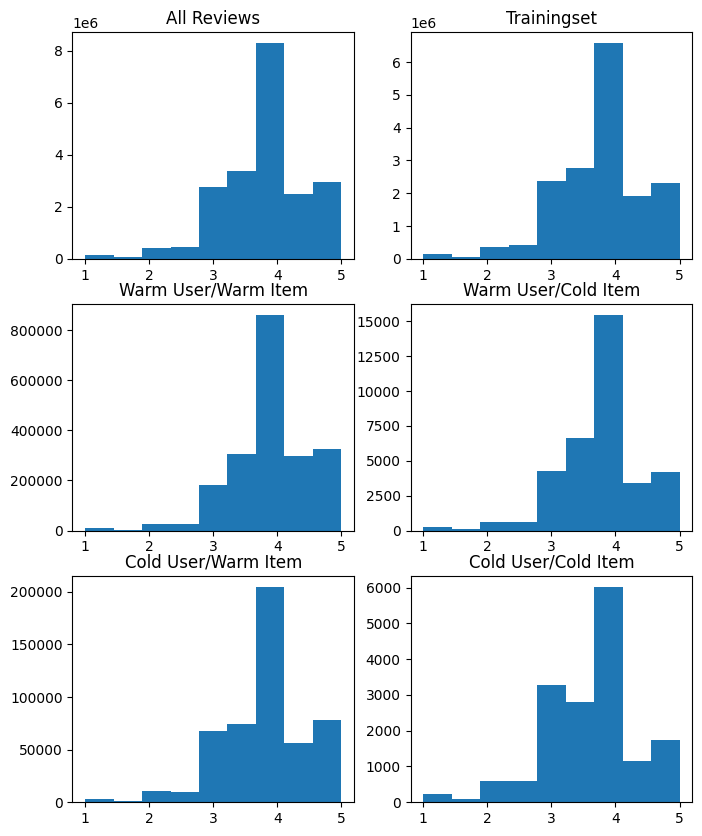

In [24]:
# rating distribution
fig, axs = plt.subplots(3,2,figsize=(8, 10))

axs[0, 0].hist(df_reviews["Rating"], bins=9)
axs[0, 0].set_title("All Reviews")

axs[0, 1].hist(df_reviews_train["Rating"], bins=9)
axs[0, 1].set_title("Trainingset")

axs[1, 0].hist(test_segments["warm_user_warm_item"]["Rating"], bins=9)
axs[1, 0].set_title("Warm User/Warm Item")

axs[1, 1].hist(test_segments["cold_item"]["Rating"], bins=9)
axs[1, 1].set_title("Warm User/Cold Item")

axs[2, 0].hist(test_segments["cold_user"]["Rating"], bins=9)
axs[2, 0].set_title("Cold User/Warm Item")

axs[2, 1].hist(test_segments["cold_user_cold_item"]["Rating"], bins=9)
axs[2, 1].set_title("Cold User/Cold Item")


##### Distribution Differences in earth-mover distance and JS

In [40]:
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from scipy.stats import chi2_contingency

hist_df_reviews = df_reviews.value_counts("Rating", normalize=True, sort=False).to_list()
hist_df_train = df_reviews_train.value_counts("Rating", normalize=True, sort=False).to_list()
hist_warm_user_warm_item = test_segments["warm_user_warm_item"].value_counts("Rating", normalize=True, sort=False).to_list()
hist_warm_user_cold_item = test_segments["cold_item"].value_counts("Rating", normalize=True, sort=False).to_list()
hist_cold_user_warm_item = test_segments["cold_user"].value_counts("Rating", normalize=True, sort=False).to_list()
hist_cold_user_cold_item = test_segments["cold_user_cold_item"].value_counts("Rating", normalize=True, sort=False).to_list()

test_hists = {"hot_user_hot_item": hist_warm_user_warm_item, 
              "hot_user_cold_item": hist_warm_user_cold_item, 
              "cold_user_hot_item": hist_cold_user_warm_item, 
              "cold_user_cold_item": hist_cold_user_cold_item}

for name, test_hist in test_hists.items():
    js = jensenshannon(hist_df_train, test_hist, base=2) ** 2  # square to get true JS divergence
    print(f"JS Divergence between train and {name}:", js)
    bin_centers = np.linspace(1.0, 5.0, 9)
    wd = wasserstein_distance(bin_centers, bin_centers, hist_df_train, test_hist)
    print(f"Wasserstein Distance between train and {name}:", wd)
    print("\n")


JS Divergence between train and hot_user_hot_item: 0.009870994325045682
Wasserstein Distance between train and hot_user_hot_item: 0.14846420284652773


JS Divergence between train and hot_user_cold_item: 0.0039639839102326956
Wasserstein Distance between train and hot_user_cold_item: 0.06269939852390342


JS Divergence between train and cold_user_hot_item: 0.0012479875634181395
Wasserstein Distance between train and cold_user_hot_item: 0.04465261000084767


JS Divergence between train and cold_user_cold_item: 0.012083432975968856
Wasserstein Distance between train and cold_user_cold_item: 0.18186293754429805




#####

### Exporting datasets

In [25]:
for test_segment in test_segments.keys():
    test_segments[test_segment].to_csv(f"testset_{test_segment}.csv", index=False)
df_reviews_train.to_csv("trainset.csv", index=False)

### Handling the imbalanced user review counts
For the hot user/cold wine and cold/cold there is an imbalanced avaerage user review count from 1.2 and 1.1 compared to the hot/hot with 6.5 and cold/hot with 10 (coming from a 80/20 temporal split)